# Etape 1

#### Lecture et traitement du jeu de données

In [4]:
import pylab as pl
import pandas as pd

T = pd.read_csv('./data/season-1819_csv.csv')

col = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
T = T[col]

T.rename(columns = {'HomeTeam' : 'DOM', 'AwayTeam' : 'EXT', 'FTHG' : 'BDOM', 'FTAG' : 'BEXT'},
         inplace = True)

T.head()

,Date,DOM,EXT,BDOM,BEXT
0,10/08/2018,Marseille,Toulouse,4,0
1,11/08/2018,Angers,Nimes,3,4
2,11/08/2018,Lille,Rennes,3,1
3,11/08/2018,Montpellier,Dijon,1,2
4,11/08/2018,Nantes,Monaco,1,3


In [5]:
len(T) #nombre de match joués en ligue 1

380

#### Nombre de buts inscrits à domicile ou à l'extérieur

In [6]:
M = T['BDOM'].value_counts().sort_index()
M

0     88
1    127
2     99
3     43
4     14
5      8
9      1
Name: BDOM, dtype: int64

- Il y a eu 88 matchs où l'équipe jouant à domcile n'a inscrit aucun but.
- Il y a eu 127 matchs où l'équipe jouant à domicile a inscrit un seul but.

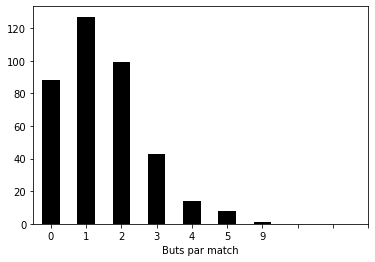

In [22]:
M.plot.bar(color = 'black')
pl.xlabel('Buts par match')
pl.xticks(range(10), rotation = 0);
# Distribution en barre du nombre de buts par match inscrit par les équipes à domicile

#### Modélisation du nombre de buts par match inscrits à domicile

Choix du modèle :

- On découpe la durée du match en 45 intervalles de 2 minutes chacune :

##### On suppose que :
- A chaque intervalle une équipe ne peut marquer qu'un seul but à la fois avec une probabilité p
- l'apparition d'un but dans un intervalle est indépendante des autres intervalles

- On note X la variable aléatoire qui pour un match donné, compte le nombre de buts inscrits par une équipe jouant à domicile.

In [11]:
m = T.mean()
m

BDOM    1.471053
BEXT    1.086842
dtype: float64

- Le nombre moyen de buts inscrits par match à domicile est de 1,47

In [12]:
m['BDOM']

1.4710526315789474

In [13]:
m['BEXT']

1.0868421052631578

- On peut avoir donc E[X] = 1,47 où E[X] est l'espérance de X

- X suit une loi Binomiale où l'espérance = np

Dans notre cas n = 45, on a donc 1.47 = 45p, donc p = 1,47/45

In [14]:
m['BDOM']/45

0.032690058479532165

- p = 0.03

#### Pertinence du modèle

In [19]:
# X = binom(n,p) permet de définir X suivant une loi binomiale de paramètre n et p
# X.pmf(k) renvoie P(X=k)

# On veut que E soit la liste des effectifs attendus du nombre de buts inscrits sur 380 matchs

from scipy.stats import binom

X = binom(45, m['BDOM']/45)
E = [380 * X.pmf(k) for k in range(7)]
E

[85.16044125864548,
 129.5091530053391,
 96.28822705154658,
 46.641277505150406,
 16.550449085090246,
 4.58641850651327,
 1.0333143683940675]

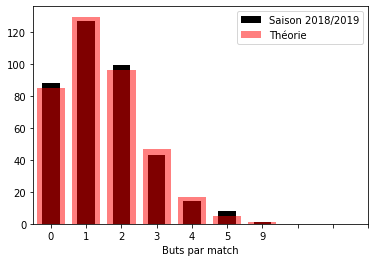

In [24]:
M.plot.bar(color = 'black')
pl.bar(range(7), E, color = 'red', alpha = 0.5, label = 'Théorie')
pl.xticks(range(10), rotation = 0)
pl.xlabel('Buts par match')
pl.legend(labels = ['Saison 2018/2019', 'Théorie']);

- On voit bien que le modèle choisit est très pertinent

####  Loi du nombre de buts inscrits par l'équipe jouant à l'extérieur

On note Y la variable aléatoire qui compte le nombre de buts inscrits par l'équipe jouant à l'extérieur

- On peut proposer une loi binomiale de paramètre n = 45 et p = 1.087/45 = 0.024

In [25]:
from scipy.stats import binom

Y = binom(45, m['BEXT']/45)
F = [380 * Y.pmf(k) for k in range(7)]
F

[126.46798425567751,
 140.85260906045798,
 76.69364211202125,
 27.20685544170944,
 7.070325919756212,
 1.4349113537392095,
 0.23675851025520794]

In [26]:
N = T['BEXT'].value_counts().sort_index()
N

0    135
1    135
2     68
3     29
4     10
5      3
Name: BEXT, dtype: int64

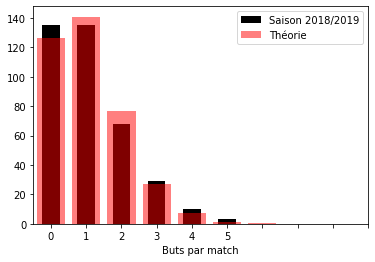

In [27]:
N.plot.bar(color = 'black')
pl.bar(range(7), F, color = 'red', alpha = 0.5, label = 'Théorie')
pl.xticks(range(10), rotation = 0)
pl.xlabel('Buts par match')
pl.legend(labels = ['Saison 2018/2019', 'Théorie']);

# Etape 2 

##### Choix du modèle :

- A partir des statistiques des 2 équipes, on modélise :

- le nombre de buts inscrits par Marseille par une variable aléatoire X
- le nombre de buts inscrits par Toulouse par une variable aléatoire Y

##### On suppose que :

- X suit une loi binomiale de paramètres n = 45 et pdom
- Y suit une loi binomiale de paramètres n = 45 et pext

##### Objectif

Estimons alors les valeurs pdom et pext à partir des calculs de moyennes de buts par match :

- inscrits par Marseille et Toulouse 
- concédés par Marseille et Toulouse

#### Performance d'attaque et de défense de Marseille

- La performance d'attaque de Marseille est (nb moyen de buts de Marseille à dom) / (nb moyen de buts inscrits en L1 à dom)

- La performance défensive de Marseille est (nb moyen de buts concédés Marseille à dom) / (nb moyen de buts concédés en L1 à dom)

In [28]:
TD = T.query('DOM == "Marseille"').mean()
TD

BDOM    1.631579
BEXT    0.894737
dtype: float64

- Marseille inscrit environ 1.63 but à Domicile et en concède 0.89

In [30]:
#On pose PerfAOM la performance d'attaque de Marseille
PerfAOM = TD['BDOM']/m['BDOM']
PerfAOM

1.10912343470483

- En moyenne, par rapport aux équipes jouant à domicile, Marseille inscrit 10,9% de buts en plus
- Par rapport à la moyenne, c'est une équipe plus offensive.

In [31]:
PerfDOM = TD['BEXT']/m['BEXT']
PerfDOM

0.8232445520581114

- En moyenne, par rapport aux équipes jouant à domicile, Marseille encaisse 17,7% de buts en plus
- Par rapport à la moyenne, c'est une équipe moins défensive.

#### Performance d'attaque et de défense de Toulouse

In [32]:
TE = T.query('EXT=="Toulouse"').mean()
TE

BDOM    1.631579
BEXT    0.789474
dtype: float64

- Toulouse inscrit environ 0.78 but à l'extérieur et en concède 1.63

In [33]:
PerfDTFC = TE['BDOM']/m['BDOM']
PerfDTFC

1.10912343470483

In [34]:
PerfATFC = TE['BEXT']/m['BEXT']
PerfATFC

0.7263922518159807

- Toulouse a une moins bonne performance d'attaque et de défense que Marseille

#### Estimations des espérances de X et de Y pour le match Marseille - Toulouse

- On estime que E[X] = Attaque Marseille * Défense Toulouse * Nb moyen de buts à domicile

- On estime que E[Y] = Attaque Toulouse * Défense Marseille * Nb moyen de buts à extérieur

In [37]:
# Ces calculs sont employés par les bookmakers au départ et peuvent être affinés 
# par des modèles statistiques plus performants.

EspX = PerfAOM*PerfDTFC*m['BDOM']
print(EspX)
EspY = PerfATFC*PerfDOM*m['BEXT']
print(EspY)

1.809622446097354
0.6499299095195616


In [42]:
def Esp(e1, e2):
    TD = T.query('DOM == @e1').mean()
    TE = T.query('EXT == @e2').mean()
    EX = TD['BDOM'] * TE['BDOM'] / m['BDOM']
    EY = TE['BEXT'] * TD['BEXT'] / m['BEXT']
    
    return EX, EY

In [43]:
Esp('Marseille', 'Toulouse')

(1.809622446097354, 0.6499299095195616)

#### Calculer la probabilité d'avoir un match nul entre ces deux équipes

- X suit une loi binomiale de paramètre n=45 et pDOM.

On sait désormais que pDOM = E[X]/45

- Y suit une loi binomiale de paramètre n=45 et pEXT.

On sait désormais que pEXT = E[Y]/45

In [45]:
pDOM = EspX/45
print(pDOM)
pEXT = EspY/45
print(pEXT)

0.04021383213549676
0.01444288687821248


- On veut que X = Y

In [53]:
X = binom(45, pDOM)
Y = binom(45, pEXT)

k=0
somme=0
for k in range(7):
    somme += X.pmf(k)*Y.pmf(k)
    
print(somme)

0.21820548533572837


- Il y a donc 21,8% de chance d'avoir un match nul